In [27]:
import os
import sys
import numpy as np
import joblib
from importlib import reload  # Import the reload function
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import utils.helpers
from utils.helpers import *  
from utils.preprocess import *  

reload(utils.helpers)
reload(utils.preprocess)
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
df = fetch_data('ETHUSDT', '1m', '2024-12-10 00:00:00', '2024-12-31 00:00:00')

Fetched data from 2024-12-10 00:00:00 to 2024-12-10 08:19:00
Fetched data from 2024-12-10 08:20:00 to 2024-12-10 16:39:00
Fetched data from 2024-12-10 16:40:00 to 2024-12-11 00:59:00
Fetched data from 2024-12-11 01:00:00 to 2024-12-11 09:19:00
Fetched data from 2024-12-11 09:20:00 to 2024-12-11 17:39:00
Fetched data from 2024-12-11 17:40:00 to 2024-12-12 01:59:00
Fetched data from 2024-12-12 02:00:00 to 2024-12-12 10:19:00
Fetched data from 2024-12-12 10:20:00 to 2024-12-12 18:39:00
Fetched data from 2024-12-12 18:40:00 to 2024-12-13 02:59:00
Fetched data from 2024-12-13 03:00:00 to 2024-12-13 11:19:00
Fetched data from 2024-12-13 11:20:00 to 2024-12-13 19:39:00
Fetched data from 2024-12-13 19:40:00 to 2024-12-14 03:59:00
Fetched data from 2024-12-14 04:00:00 to 2024-12-14 12:19:00
Fetched data from 2024-12-14 12:20:00 to 2024-12-14 20:39:00
Fetched data from 2024-12-14 20:40:00 to 2024-12-15 04:59:00
Fetched data from 2024-12-15 05:00:00 to 2024-12-15 13:19:00
Fetched data from 2024-1

In [ ]:
helpers.load_data

In [15]:
new_df = preprocess.create_indicators(df, 5)

In [6]:
new_df

,MFI,HT_DCPERIOD,NATR,ATR,HT_DCPHASE,close
0,2.699612,25.154069,0.130946,4.930104,96.934165,3765.00
1,0.295679,24.588866,0.125762,4.732240,109.590545,3762.84
2,0.398120,24.059199,0.116779,4.394222,122.307309,3762.84
3,0.405312,23.780233,0.108438,4.080349,132.660181,3762.84
4,0.392640,23.504086,0.111720,4.197467,154.135048,3757.12
...,...,...,...,...,...,...
30172,95.079370,26.807545,0.016969,0.570788,251.332143,3363.63
30173,95.079370,25.425752,0.015757,0.530018,268.865588,3363.63
30174,99.214249,24.125211,0.014632,0.492159,301.685064,3363.63
30175,99.214249,22.940122,0.013587,0.457005,-8.531859,3363.63


In [7]:
X, y = preprocess.create_targets(new_df, 100, 50, 50)

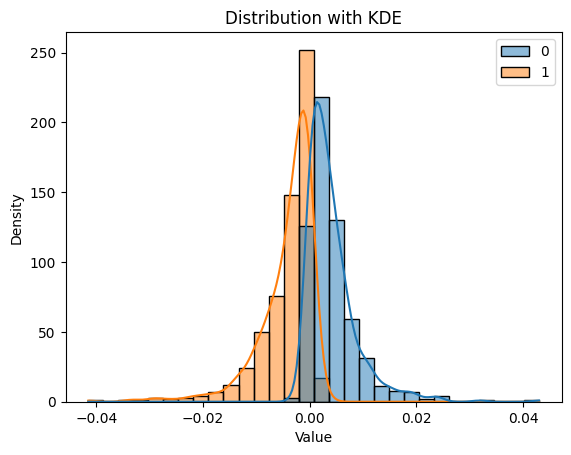

In [8]:
utils.distribution_plot(y)

In [9]:
x0, x2, y0, y1 = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
scaled_data0, scaled_data1, scaler_y = preprocess.normalize_y(y0, y1, return_scaler=True)

In [11]:
joblib.dump(scaler_y, 'data/proccessed/scaler_y.pkl')


['scaler_y.pkl']

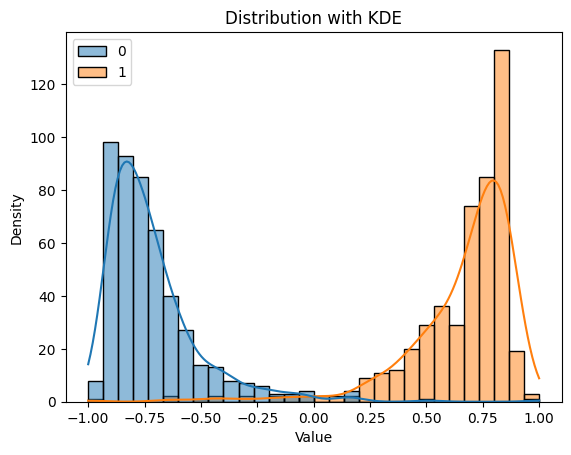

In [96]:
utils.distribution_plot(scaled_data0)

In [103]:
rescaled = scaler_y.inverse_transform(scaled_data1)


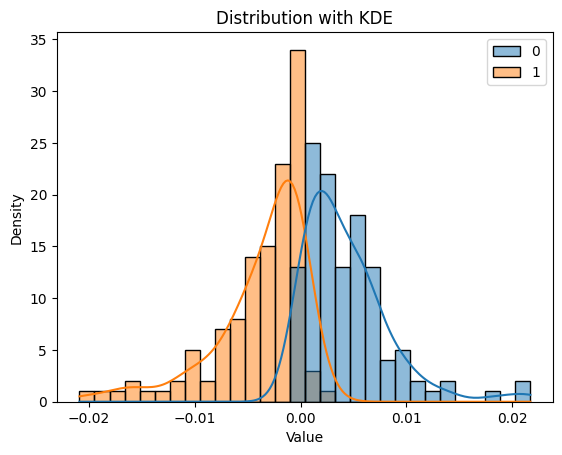

In [104]:
utils.distribution_plot(rescaled)